## Useful functions

In [1]:
from graph_manipulation import *
from betwenness_computation import *
from error_measurements import *


## Used datasets

In [2]:

graphs_dataset = [
    {
        "filepath": 'datasets/socfb-American75/socfb-American75.mtx',
        "library": None,
        "name": "socfb-American75",
        "approximation_rate": 0.1
    },
    {
        "filepath": 'datasets/socfb-American75/socfb-American75.mtx',
        "library": None,
        "name": "socfb-American75",
        "approximation_rate": 0.3
    },
    {
        "filepath": None,
        "library": nx.karate_club_graph(),
        "name": "Karate Club",
        "approximation_rate": 0.3
    }
    #'datasets/socfb-Auburn71/socfb-Auburn71.mtx'
]



## Iperparameters

## Graph loading

In [4]:
graphs = [create_graph_from_mtx_library(graph_data["filepath"], graph_data["library"]) for graph_data in graphs_dataset]

print(graphs)

Graph: datasets/socfb-American75/socfb-American75.mtx loaded
Number of nodes: 6386
Number of edges: 217663
Graph: datasets/socfb-American75/socfb-American75.mtx loaded
Number of nodes: 6386
Number of edges: 217663
[<networkx.classes.graph.Graph object at 0x10a2acef0>, <networkx.classes.graph.Graph object at 0x105f1bb90>, <networkx.classes.graph.Graph object at 0x10a55c680>]


### Exact betwenness calculation


**Algoritmo Utilizzato**: **Algoritmo di Brandes**

**Descrizione**:
- L'algoritmo di Brandes è l'algoritmo standard per il calcolo esatto della betweenness centrality. Questo algoritmo sfrutta una combinazione di attraversamenti in ampiezza del grafo e calcoli di somme per determinare il numero di percorsi più brevi che passano attraverso ciascun nodo.
- La complessità computazionale dell'algoritmo è \(O(nm)\) per grafi non pesati e \(O(nm + n^2 \log n)\) per grafi pesati, dove \(n\) è il numero di nodi e \(m\) è il numero di archi nel grafo. Questo lo rende efficiente per grafi di dimensioni moderate, ma può diventare oneroso per grafi molto grandi.

**Implementazione in NetworkX**:
- NetworkX utilizza l'algoritmo di Brandes per calcolare la betweenness centrality quando si utilizza la funzione `betweenness_centrality(graph)` senza parametri aggiuntivi.


In [5]:
exact_results = []
for i, g in enumerate(graphs):
    betweenness_exact, computation_time = calculate_betweenness_centrality(g)
    exact_results.append((betweenness_exact, computation_time))
    print(f"Graph {i+1} - Computation time: {computation_time} seconds")



Graph 1 - Computation time: 247.56909203529358 seconds
Graph 2 - Computation time: 243.46190214157104 seconds
Graph 3 - Computation time: 0.0009992122650146484 seconds


### Betweenness Centrality Approssimata

**Algoritmo Utilizzato**: **Campionamento Randomizzato Basato su Algoritmo di Brandes**

**Descrizione**:
- Per approssimare la betweenness centrality, NetworkX implementa una versione modificata dell'algoritmo di Brandes che utilizza il campionamento randomizzato. Invece di calcolare i percorsi più brevi tra tutte le coppie di nodi, l'algoritmo seleziona un sottoinsieme casuale di nodi (specificato dal parametro `k`) e calcola la centralità solo per questi nodi.
- Questo metodo riduce significativamente il tempo di calcolo, soprattutto per grafi di grandi dimensioni, a scapito di una minore precisione. La qualità dell'approssimazione dipende dal numero di nodi campionati (`k`): un numero maggiore di campioni migliora l'accuratezza dell'approssimazione.

**Implementazione in NetworkX**:
- Quando si utilizza la funzione `nx.betweenness_centrality()` con il parametro `k` specificato (ad esempio, `k=5`), NetworkX esegue un'approssimazione della betweenness centrality utilizzando il campionamento randomizzato. Il parametro `seed` può essere usato per garantire che i risultati siano riproducibili, utilizzando lo stesso set di campioni ogni volta.

In [6]:
approx_results = []
for i, g in enumerate(graphs):
    betweenness_approx, computation_time = calculate_betweenness_centrality_approximated(g, graphs_dataset[i]["approximation_rate"])
    approx_results.append((betweenness_approx, computation_time))
    print(f"Graph {i+1} - Computation time: {computation_time} seconds")

Graph 1 - Computation time: 24.42547607421875 seconds
Graph 2 - Computation time: 71.95542812347412 seconds
Graph 3 - Computation time: 0.00033402442932128906 seconds


## Results
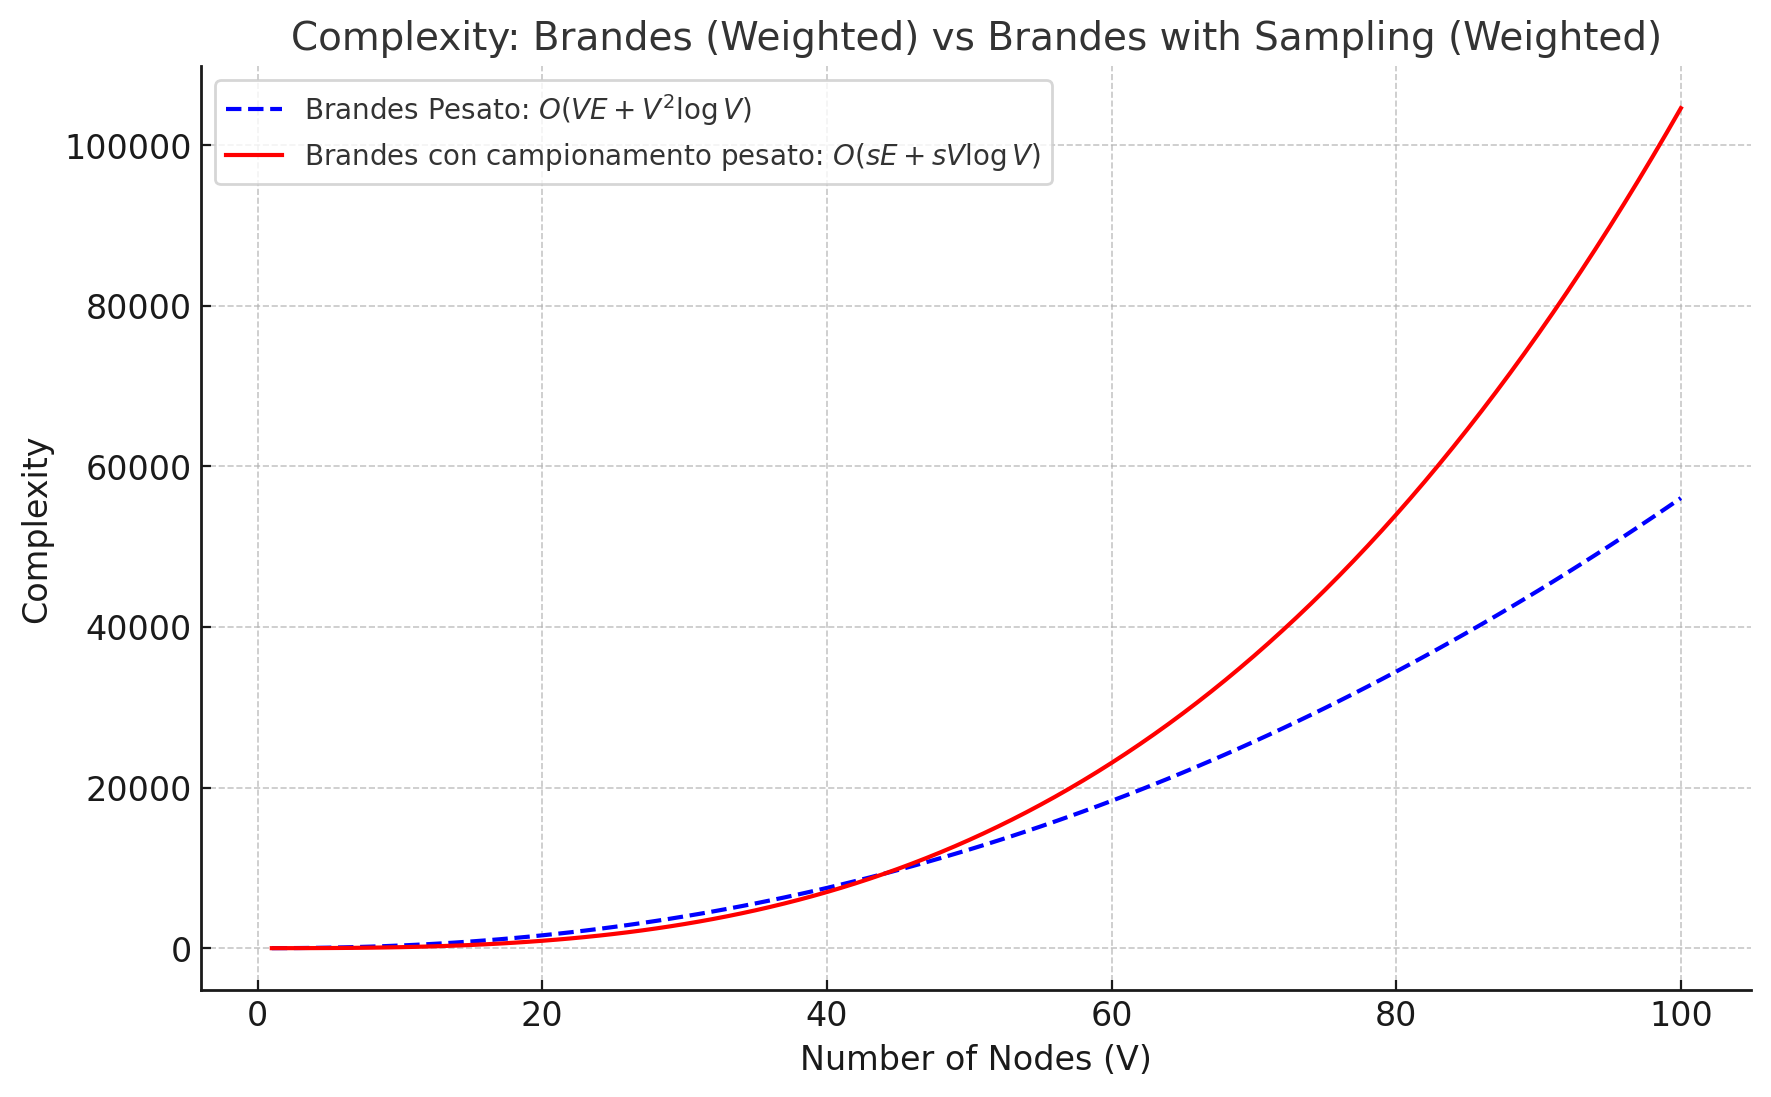

In [7]:
from tabulate import tabulate

#top N nodes
N = 20 

for i, (exact, approx) in enumerate(zip(exact_results, approx_results)):
    graph_name = f"Graph {i+1}"
    top_n_exact = get_top_n_betweenness(exact[0], N)
    top_n_approx = get_top_n_betweenness(approx[0], N)
    
    top_n_data = []
    for rank, ((node_exact, betw_exact), (node_approx, betw_approx)) in enumerate(zip(top_n_exact, top_n_approx), 1):
        top_n_data.append([rank, node_exact, betw_exact, node_approx, betw_approx])
    
    # Define table headers for top N nodes
    top_n_headers = ["Rank", "Exact Node", "Exact Betweenness", "Approx Node", "Approx Betweenness"]
    
    # Print the top N nodes table for the current graph
    print(f"\n{graph_name} - Top {N} Nodes by Betweenness Centrality")
    print(tabulate(top_n_data, headers=top_n_headers, tablefmt="grid"))


Graph 1 - Top 20 Nodes by Betweenness Centrality
+--------+--------------+---------------------+---------------+----------------------+
|   Rank |   Exact Node |   Exact Betweenness |   Approx Node |   Approx Betweenness |
+========+==============+=====================+===============+======================+
|      1 |          224 |          0.0417423  |           224 |           0.0385494  |
+--------+--------------+---------------------+---------------+----------------------+
|      2 |         4046 |          0.0232396  |          4046 |           0.021724   |
+--------+--------------+---------------------+---------------+----------------------+
|      3 |         4485 |          0.0128879  |          4780 |           0.0122616  |
+--------+--------------+---------------------+---------------+----------------------+
|      4 |         2442 |          0.0109526  |          1065 |           0.0118898  |
+--------+--------------+---------------------+---------------+-----------------

In [8]:
## Results

# Calculate mean squared error for each graph
mse_results = []
for exact, approx in zip(exact_results, approx_results):
    exact_values = list(exact[0].values())
    approx_values = list(approx[0].values())
    
    # Calculate mean squared error between all values
    mse = mean_squared_error(exact_values, approx_values)
    
    # Calculate the percentage error
    mean_exact = sum(exact_values) / len(exact_values)
    mse_percentage = (mse / mean_exact) * 100
    
    mse_results.append(mse_percentage)


nodes_in_exact_not_in_approx = []
# Calculate Nodes in Exact Not in Approx
exact_nodes = {node for node, _ in top_n_exact}
approx_nodes = {node for node, _ in top_n_approx}
nodes_not_in_approx = len(exact_nodes - approx_nodes)
nodes_in_exact_not_in_approx.append(f"{nodes_not_in_approx}/{N}")

# Prepare data for the table
data = []
for i, (exact, approx, mse) in enumerate(zip(exact_results, approx_results, mse_results)):
    graph_name = f"Graph {i+1}"
    exact_time = float(exact[1])
    approx_time = float(approx[1])
    time_diff_percentage = f"{(((exact_time - approx_time) / exact_time) * 100):.2f}%"  # Corrected formatting
    mse_value = f"{mse:.8f}%"  # Use mse from mse_results

    data.append([graph_name, exact_time, approx_time, time_diff_percentage, mse_value, nodes_not_in_approx])

# Define table headers
headers = ["Graph", "Exact Time (s)", "Approx Time (s)", "Speedup(%)", "MSE", "Nodes in Exact Not in Approx"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------+------------------+-------------------+--------------+-------------+--------------------------------+
| Graph   |   Exact Time (s) |   Approx Time (s) | Speedup(%)   | MSE         |   Nodes in Exact Not in Approx |
+=========+==================+===================+==============+=============+================================+
| Graph 1 |    247.569       |      24.4255      | 90.13%       | 0.01048955% |                              0 |
+---------+------------------+-------------------+--------------+-------------+--------------------------------+
| Graph 2 |    243.462       |      71.9554      | 70.44%       | 0.00279337% |                              0 |
+---------+------------------+-------------------+--------------+-------------+--------------------------------+
| Graph 3 |      0.000999212 |       0.000334024 | 66.57%       | 1.62384189% |                              0 |
+---------+------------------+-------------------+--------------+-------------+-----------------

In [9]:
## Results

mse_results = []
for exact, approx in zip(exact_results, approx_results):
    exact_values = list(exact[0].values())
    approx_values = list(approx[0].values())
    
    # Calculate mean squared error between all values
    mse = mean_squared_error(exact_values, approx_values)
    
    # Calculate the percentage error
    mean_exact = sum(exact_values) / len(exact_values)
    mse_percentage = (mse / mean_exact) * 100
    
    mse_results.append(mse_percentage)


nodes_in_exact_not_in_approx = []

exact_nodes = {node for node, _ in top_n_exact}
approx_nodes = {node for node, _ in top_n_approx}
nodes_not_in_approx = len(exact_nodes - approx_nodes)
nodes_in_exact_not_in_approx.append(f"{nodes_not_in_approx}/{N}")

data = []
for i, (exact, approx, mse) in enumerate(zip(exact_results, approx_results, mse_results)):
    graph_name = graphs_dataset[i]["name"]
    k_value = graphs_dataset[i]["approximation_rate"]
    exact_time = float(exact[1])
    approx_time = float(approx[1])
    time_diff_percentage = f"{(((exact_time - approx_time) / exact_time) * 100):.2f}%"  # Corrected formatting
    mse_value = f"{mse:.8f}%"  # Use mse from mse_results
    num_nodes = len(exact[0])  # Number of nodes in the graph

    data.append([graph_name, k_value, num_nodes, exact_time, approx_time, time_diff_percentage, mse_value, nodes_not_in_approx])

headers = ["Graph", "k Value", "Number of Nodes", "Exact Time (s)", "Approx Time (s)", "Speedup(%)", "MSE(%)", "Nodes in Exact Not in Approx"]

print(tabulate(data, headers=headers, tablefmt="grid"))

# TODO: errore lineare (valore assoluto), errore di posizionamento (sia media che varianza), scatterplot per l'errore di poszionamento (colore in base al posizionamento del nodo in scala colore (scuro importante, chiaro non importante --> usare library seaborn))

+------------------+-----------+-------------------+------------------+-------------------+--------------+-------------+--------------------------------+
| Graph            |   k Value |   Number of Nodes |   Exact Time (s) |   Approx Time (s) | Speedup(%)   | MSE(%)      |   Nodes in Exact Not in Approx |
+==================+===========+===================+==================+===================+==============+=============+================================+
| socfb-American75 |       0.1 |              6386 |    247.569       |      24.4255      | 90.13%       | 0.01048955% |                              0 |
+------------------+-----------+-------------------+------------------+-------------------+--------------+-------------+--------------------------------+
| socfb-American75 |       0.3 |              6386 |    243.462       |      71.9554      | 70.44%       | 0.00279337% |                              0 |
+------------------+-----------+-------------------+------------------+-----